# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells run and is stored in your team's [Github Classroom repository](https://classroom.github.com/a/CNxME27U). You will also need to write a short, 2 page report about your design decisions as a team, to be stored in your repository. The Milestone 4 submission will be the contents of your repository at the due date (April 28 at 23:59 CET).

## Brief overview of Calcularis
[Calcularis](https://school.alemira.com/de/calcularis/) by Alemira School is a mathematics learning program developed with neuroscientists and computer scientists from ETH Zurich. It promotes the development and interaction of the different areas of the brain that are responsible for processing numbers and quantities and solving mathematical tasks. Calcularis can be used from 1st grade to high school. Children with dyscalculia also benefit in the long term and overcome their arithmetic weakness.

The Calcularis dataset has three main tables:
* ***users***: meta information about users (i.e. total time spent learning with Calcularis, geographic location).
* ***events***: events done by the users in the platform (i.e. playing a game, selecting a new animal in the zoo simulation).
* ***subtasks***: sub-tasks with answer attempts solved by users, primarily in the context of game events.

These tables and useful metadata information are described in detail in the [Milestone 2 data exploration notebook](https://github.com/epfl-ml4ed/mlbd-2023/blob/main/project/milestone-02/m2_calcularis_sciper.ipynb).

We have provided access to the [full dataset](https://moodle.epfl.ch/mod/forum/discuss.php?d=88179) (~65k users) and a randomly selected subset (~1k users from M2). We have also provided access to a [test account to experiment with Calcularis](https://moodle.epfl.ch/mod/forum/discuss.php?d=88094). You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [1]:
# Import the tables of the data set as dataframes.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


DATA_DIR = 'data' # You many change the directory

# You can use the nrows=X argument in pd.read_csv to truncate your data
users = pd.read_csv('{}/calcularis_small_users.csv'.format(DATA_DIR))
events = pd.read_csv('{}/calcularis_small_events.csv'.format(DATA_DIR))
subtasks = pd.read_csv('{}/calcularis_small_subtasks.csv'.format(DATA_DIR), index_col=0)

## Task 0: Research Question

**Research question:**
How can we define how good a certain student’s knowledge is for a certain skill, and can we predict how long it will take for them to progress in or master a certain skill ?

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

In [13]:
# extract game_name and number_range from the events dataframe to match the subtasks dataframe (given the event_id)
game_name = subtasks.merge(events[['event_id', 'game_name']], on='event_id', how='left').game_name
number_range = subtasks.merge(events[['event_id', 'number_range']], on='event_id', how='left').number_range

#split the game_name into skills
game_in_skill = {'Number representation': ['Subitizing', 'Conversion', 'Estimation', 'Estimation on Number Line', 'Scale: Conversion', 'Landing'], 'Number comparison/manipulation': ['Comparison', 'Secret Number', 'Distance', 'Scale: Composition', 'Order'], 'Addition/Substraction': ['Scale: Decomposition', 'Scale: Subtraction', 'Scale: Subtraction by Tens and Ones', 'Sliderule', 'Plus-minus', 'Difference', 'Completion', 'Calculator'], 'Multiplication/Division': ['Write as multiplication', 'Shelf: Jump Ahead', 'Shelf: given height', 'Shelf: random height', 'Distribution', 'Calculator: Multiplication', 'Calculator: Multiplication with ?', 'Calculator: Division', 'Jump backwards', 'Series']}
skill = game_name.apply(lambda x: 'Number representation' if x in game_in_skill['Number representation'] 
                        else 'Number comparison/manipulation' if x in game_in_skill['Number comparison/manipulation'] 
                        else 'Addition/Substraction' if x in game_in_skill['Addition/Substraction']
                        else 'Multiplication/Division' if x in game_in_skill['Multiplication/Division']
                        else 'Other')
# concatenate skills and number range and add it to the subtasks dataframe
subtasks['skill_name'] = skill + ' ' + number_range

### Proportion of tasks in each skill and difficulty range

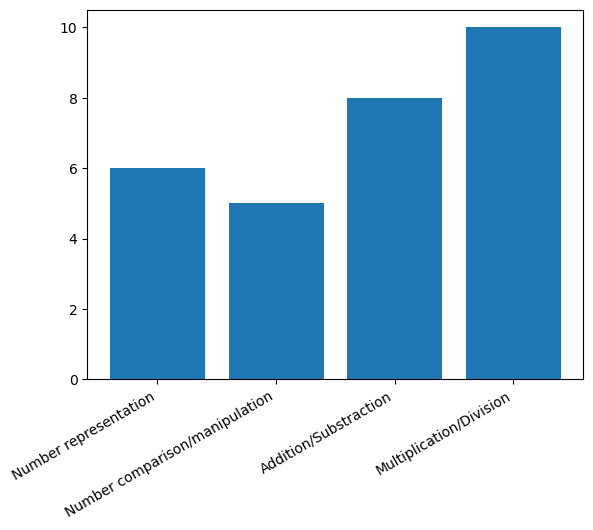

In [32]:
game_count = {k:len(v) for k, v in game_in_skill.items()}
plt.bar(*zip(*game_count.items()))
plt.xticks(rotation=30, horizontalalignment='right')
plt.show()


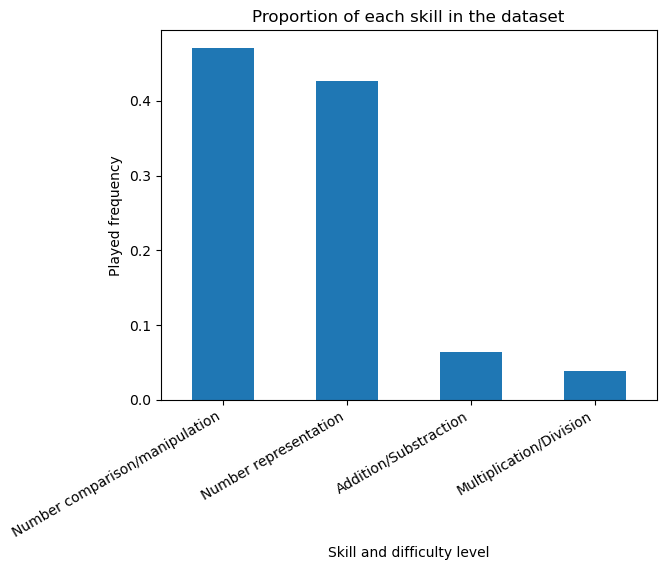

In [21]:
skills_proportion = (skill.value_counts()/len(skill)).sort_values(ascending=False)
skills_proportion.plot.bar()
plt.xticks(rotation=30, horizontalalignment='right')
plt.title('Proportion of each skill in the dataset')
plt.xlabel('Skill and difficulty level')
plt.ylabel('Played frequency')
plt.show()

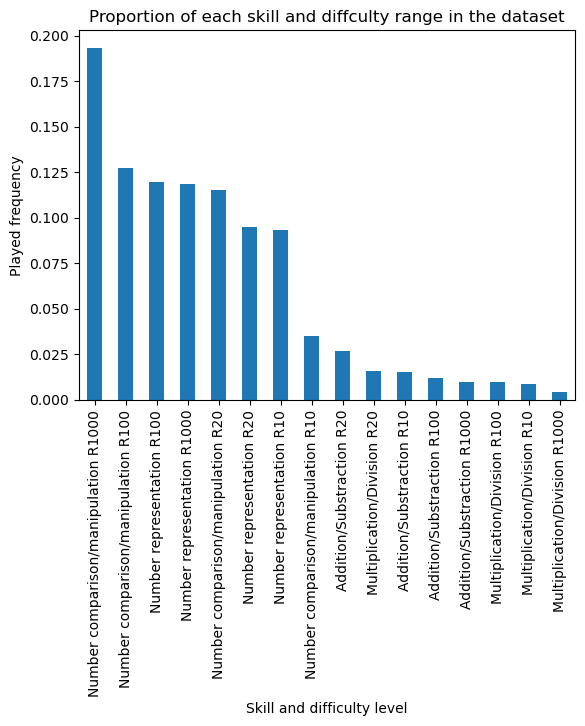

In [25]:
skills_proportion = (subtasks.groupby('skill_name').size()/len(subtasks)).sort_values(ascending=False)
skills_proportion.plot.bar()
#plt.xticks(rotation=30, horizontalalignment='right')
plt.title('Proportion of each skill and diffculty range in the dataset')
plt.xlabel('Skill and difficulty level')
plt.ylabel('Played frequency')
plt.show()

Our goal is to use knowledge tracing algorithms to predict students' knowledge level for a certain skill. We decided to group the games into 4 skills, namely Number representation, Number comparison/manipulation, Addition/Subtraction and Multiplication/Division. 
explanation of the skills visualization plot :
We have done plots to show the proportion of each skill in the dataset. We can see that Number comparison/manipulation and Number representation are largely the most represented skills, followed by Addition/Subtraction and Multiplication/Division. This is not surprising as the first two skills are the most basic ones (so every new user practice them), and the last two are more advanced. The dataset is not really balanced even if we add more games in the least represented skills but we think it is not a problem as we are trying to predict the knowledge level for each skill separately, so as long as we have enough data for each skill, it is fine.
To evaluate the level of mastering of the students, we use as a metric the probability of answering correctly to each question, we will therefore use the subtasks dataset which contains for each attempt of the users, if the given answer is correct or not.

## Task 2: Model Building

Train a model for your research question. 

##### Check the distribution of the different probabilities learned by the BKT model (learn, forget, slip, guess) among the users and the skills

In [34]:
from pyBKT.models import Model

In [35]:
model = Model(seed=0, defaults={'order_id' : 'subtask_id'})
model.fit(data=subtasks, 
          multilearn = 'user_id',
          multigs = 'user_id',
          forgets = True)

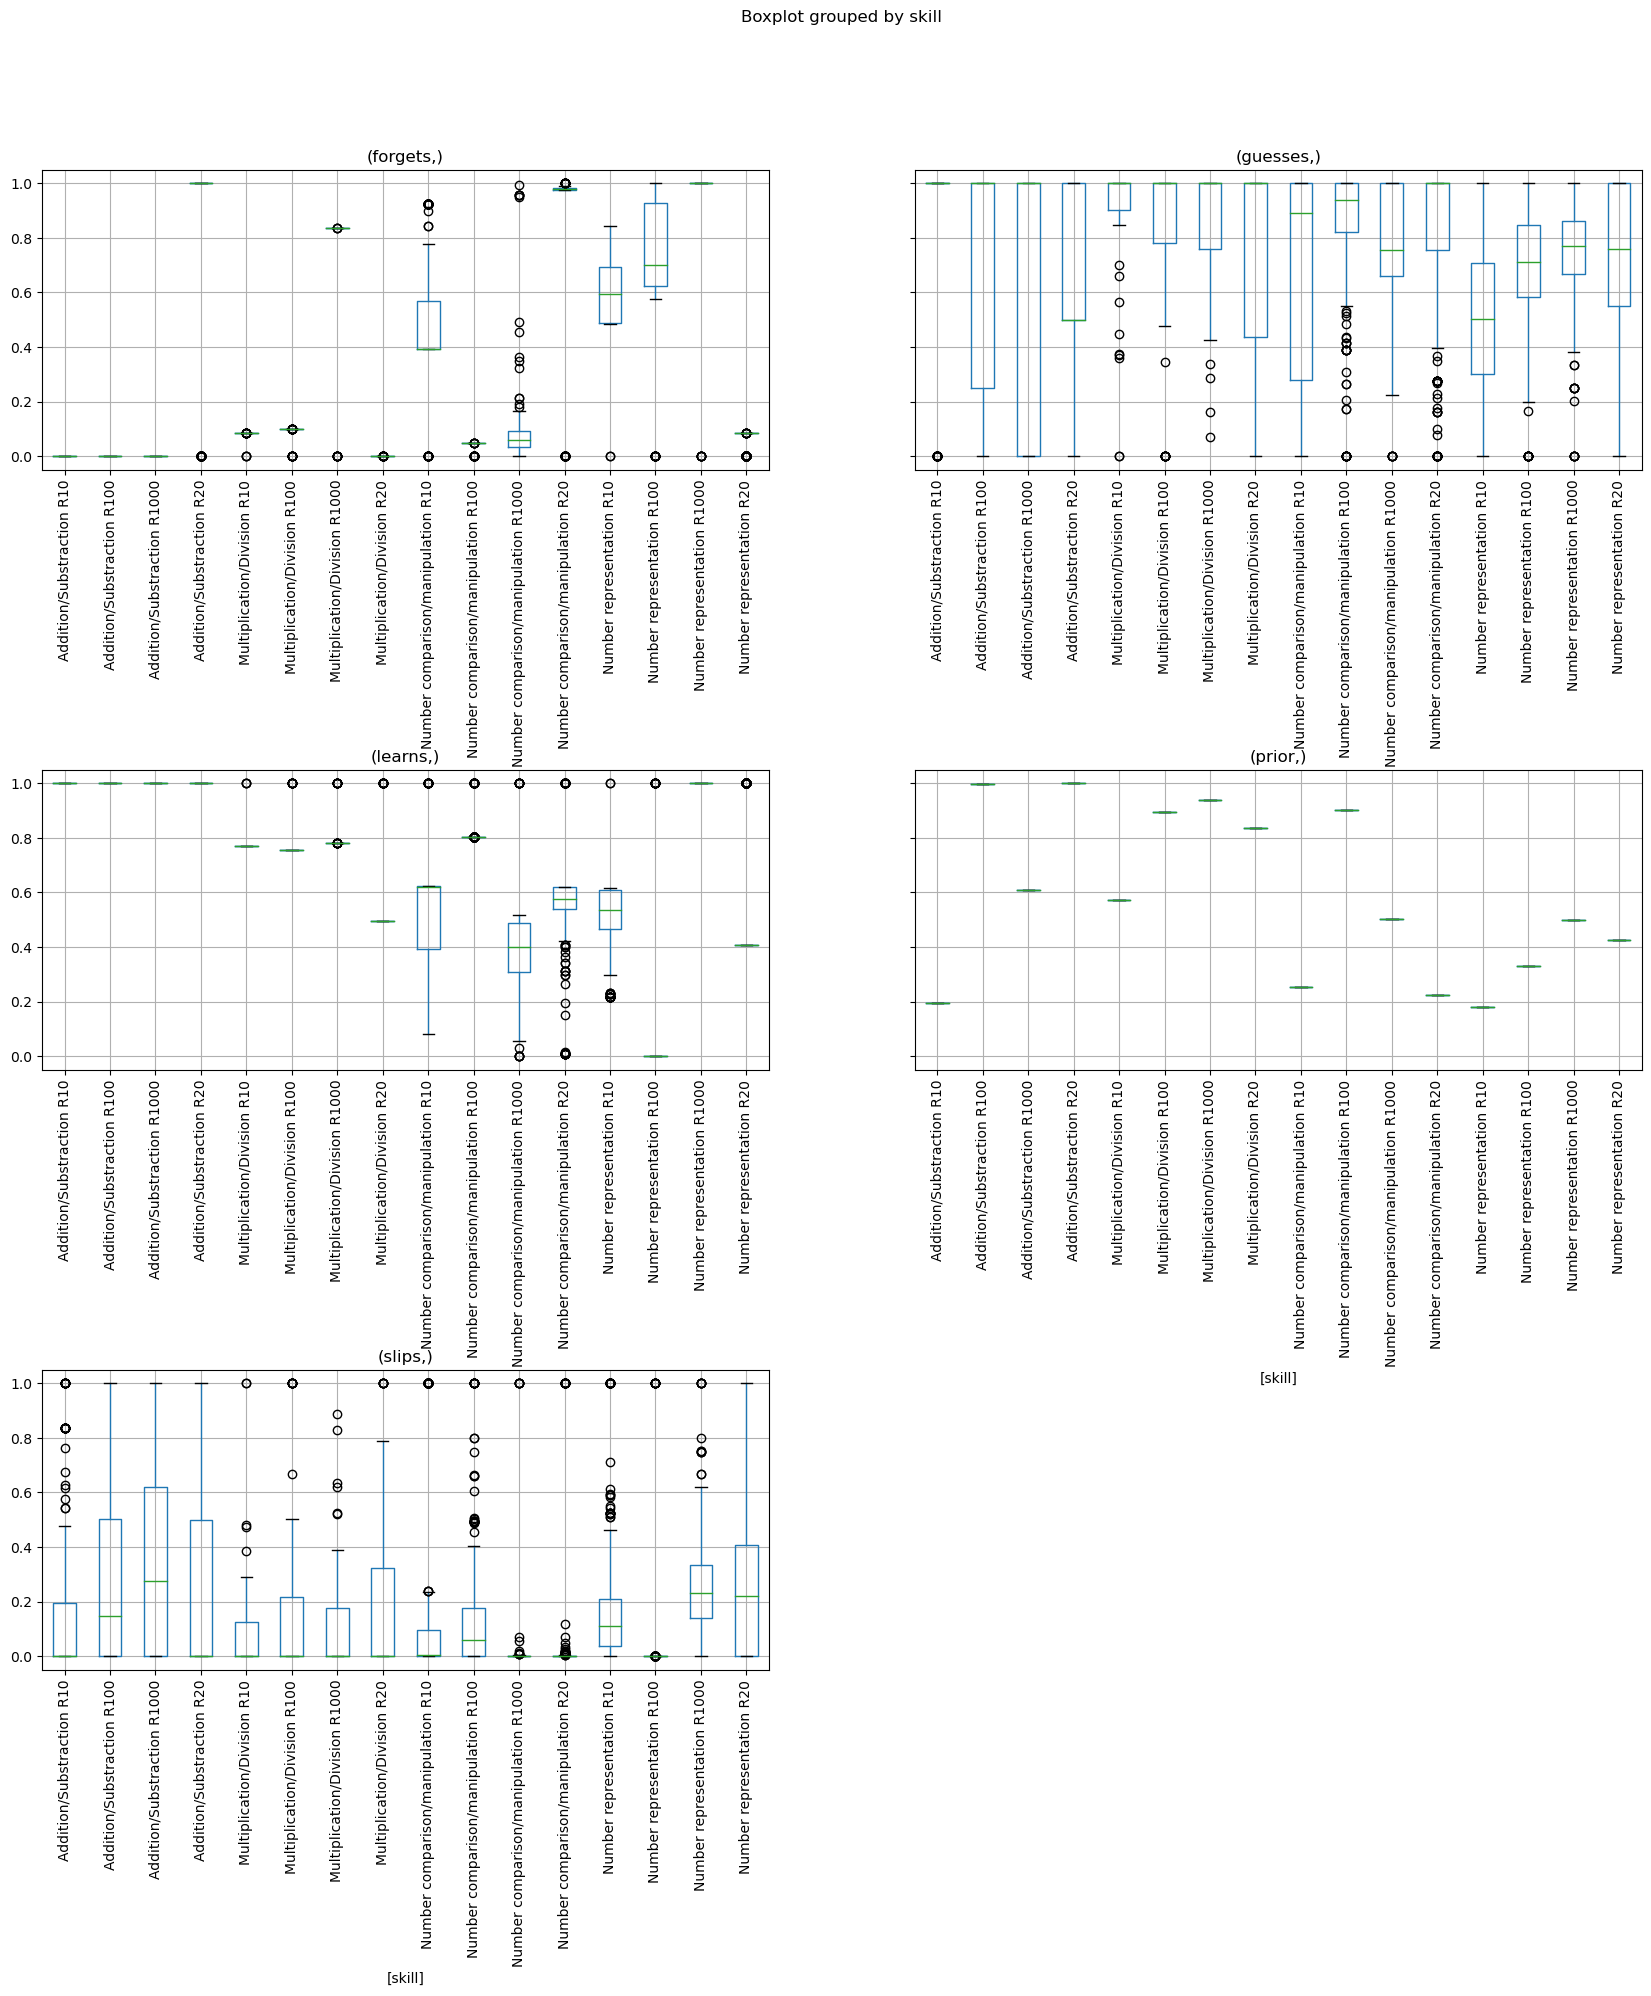

In [36]:
params = model.params()
params.groupby(['param']).boxplot(by=['skill'], figsize=(20,20), rot=90)
plt.subplots_adjust(hspace = 1)
plt.show()

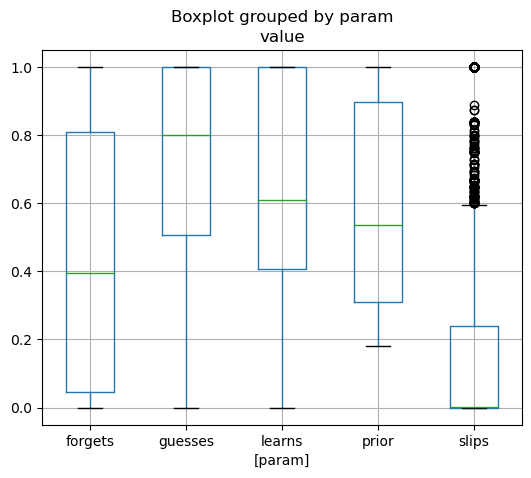

In [41]:
params = model.params()
params.boxplot(by=['param'], figsize=(6,5))
plt.show()

#### Model to predict the probability of answering correctly to the next question and to have mastered the skill

*Your discussion about your model training goes here*

## Task 3: Model Evaluation
In this task, you will use metrics to evaluate your model.

In [ ]:
# Your code for model evaluation goes here

*Your discussion/interpretation about your model's behavior goes here*

## Task 4: Team Reflection
Please describe the contributions of each team member to Milestone 4. Reflect on how you worked as team: what went well, what can be improved for the next milestone?

*Your discussion about team responsibilities goes here*